## Setup the Environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
import os

main_df = zipfile.ZipFile('/content/drive/MyDrive/Kaggle Project/planet-understanding-the-amazon-from-space.zip', 'r') #Opens the zip file in read mode
main_df.extractall('/tmp') #Extracts the files into the /tmp folder
main_df.close()

In [5]:
!pip install pyunpack
!pip install patool



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 1.9 MB/s 


In [6]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/Kaggle Project/train-jpg.tar').extractall('/tmp')
Archive('/content/drive/MyDrive/Kaggle Project/test-jpg.tar').extractall('/tmp')
Archive('/content/drive/MyDrive/Kaggle Project/test-jpg-additional.tar').extractall('/tmp')
# !tar -xvf train-train_jpg.tar

In [7]:
# !ls -al /content/drive/MyDrive/Colab\ Notebooks

In [8]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


## Import Relevant Libraries

In [9]:
import sys
import os
import subprocess
from six import string_types
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import scipy
from skimage import io
from scipy import ndimage
from tqdm import tqdm
from IPython.display import display
%matplotlib inline

import cv2
import gc
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow import keras
from keras.models import Sequential , Model
from keras.layers import Input,  Dropout
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Viewing the training Data

In [10]:
train_classes_df = pd.read_csv('/tmp/train_v2.csv/train_v2.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## Viewing the Testing Data

In [11]:
# Same as test csv
sample_submission_df = pd.read_csv('/tmp/sample_submission_v2.csv/sample_submission_v2.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [12]:
!ls /tmp/train-jpg | wc -l

40479


## Data Preprocessing

we'll be reshaping the images and also normalizing them.

we'll One-hot encode the labels and split our training data into training and validation

In [13]:
test1 = !ls /tmp/test-jpg | wc -l
test2 = !ls /tmp/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [14]:
image_number = 40
img = io.imread('/tmp/train-jpg/train_{}.jpg'.format(image_number))

In [15]:
img.shape

(256, 256, 3)

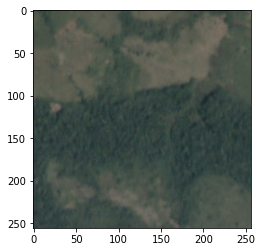

In [16]:
plt.imshow(img)

In [17]:
train_classes_df[train_classes_df['image_name'] == 'train_40']

,image_name,tags
40,train_40,agriculture clear cultivation primary


In [18]:
# Checking for Unique Labels
unique_tags = set()
def unique_labels(tags):
  for tag in tags.split():
    unique_tags.add(tag)

train_df = train_classes_df.copy()
train_df['tags'].apply(unique_labels)
unique_tags = list(unique_tags)
print(unique_tags)

['water', 'bare_ground', 'cultivation', 'artisinal_mine', 'agriculture', 'habitation', 'road', 'slash_burn', 'cloudy', 'primary', 'partly_cloudy', 'selective_logging', 'blooming', 'conventional_mine', 'haze', 'clear', 'blow_down']


In [19]:
# Adding One-hot-encoded features for all labels
for tag in unique_tags:
  train_df[tag] = train_df['tags'].apply(lambda x: 1 if tag in x.split() else 0)

# We add .jpg extension to 'image_name'
train_df['image_name'] = train_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_df.head()

,image_name,tags,water,bare_ground,cultivation,artisinal_mine,agriculture,habitation,road,slash_burn,cloudy,primary,partly_cloudy,selective_logging,blooming,conventional_mine,haze,clear,blow_down
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0


In [20]:
y_col = list(train_df.columns[2:]) # Storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

img_resize = (224, 224)
# Loading the images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_df, \
                                  directory='/tmp/train-jpg', x_col='image_name', y_col=y_col, \
                                  target_size=img_resize, class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [21]:
# X is an iterable, it contains 317 batches, each batch contains 128 images and labels because
# 40479 / 128 is 316 remainder 31. 
# Each image is of shape (128, 128, 3)
# Each label is of shape (17,)

# Let's abitrarily view an image
x120 = X[0][0][120] # first batch, images 120th image
y120 = X[0][1][120] # first batch, labels, 120th label
print("each image's shape is {}".format(x120.shape))
print("each label's shape is {}".format(y120.shape))
print("we have {} batches".format(len(X)))
print("each batch has {} images/labels".format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (224, 224, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


In [22]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau
#model= keras.applications.nasnet.NASNetLarge()

In [23]:
from keras import backend as K
def fbeta_score(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

## Model Architecture




In [24]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(17, activation='sigmoid')(x)

# this is the model we will train
models = Model(inputs=base_model.input, outputs=predictions)

87924736/87910968 [==============================] - 2s 0us/step


In [25]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

# creating 80% of the image data for training
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_df, \
                                                directory='/tmp/train-jpg', x_col='image_name', y_col=y_col, \
                                                target_size=img_resize, class_mode='raw', seed=0, batch_size=128, subset='training')

val_gen = train_image_gen.flow_from_dataframe(dataframe=train_df, \
                                                directory='/tmp/train-jpg', x_col='image_name', y_col=y_col, \
                                                target_size=img_resize, class_mode='raw', seed=0, batch_size=128, subset='validation')


Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [26]:
from keras.callbacks import *

In [29]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#models.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy')

history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=2, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, cooldown=0, min_lr=1e-7, verbose=2),
             ModelCheckpoint(filepath='/tmp/best_new_model.hdf5', monitor='val_fbeta', verbose=2, save_best_only=True, \
                             save_weights_only=True, mode='auto')]


# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

models.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics = ['accuracy', fbeta_score])
# train the model on the new data for a few epochs
models.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=5, callbacks=callbacks)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/5
253/253 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.4945 - fbeta_score: 0.8022 

253/253 [==============================] - 4471s 18s/step - loss: 0.1496 - accuracy: 0.4945 - fbeta_score: 0.8022 - val_loss: 0.1265 - val_accuracy: 0.5204 - val_fbeta_score: 0.8312 - lr: 0.0010
Epoch 2/5
253/253 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.5039 - fbeta_score: 0.8324 

253/253 [==============================] - 4522s 18s/step - loss: 0.1225 - accuracy: 0.5039 - fbeta_score: 0.8324 - val_loss: 0.1191 - val_accuracy: 0.5201 - val_fbeta_score: 0.8394 - lr: 0.0010
Epoch 3/5
253/253 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.5041 - fbeta_score: 0.8402 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


253/253 [==============================] - 4521s 18s/step - loss: 0.1171 - accuracy: 0.5041 - fbeta_score: 0.8402 - val_loss: 0.1192 - val_accuracy: 0.5107 - val_fbeta_score: 0.8268 - lr: 0.0010
Epoch 4/5
253/253 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.5091 - fbeta_score: 0.8532 

253/253 [==============================] - 4435s 18s/step - loss: 0.1066 - accuracy: 0.5091 - fbeta_score: 0.8532 - val_loss: 0.1145 - val_accuracy: 0.5225 - val_fbeta_score: 0.8443 - lr: 2.0000e-04
Epoch 5/5
253/253 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.5092 - fbeta_score: 0.8564 
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


253/253 [==============================] - 4443s 18s/step - loss: 0.1038 - accuracy: 0.5092 - fbeta_score: 0.8564 - val_loss: 0.1145 - val_accuracy: 0.5200 - val_fbeta_score: 0.8436 - lr: 2.0000e-04


In [31]:
# Sequential model for testing
#loading the weight of a trained inceptionv3 model
models.load_weights('/tmp/best_new_model.hdf5')

OSError: ignored

In [32]:
# Let's add .jpg extension to 'image_name' in the sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [33]:
# Selecting 40669 'image_name' s' from the submission_sample dataframe to generate image data from
# test.jpg folder

test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [34]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='/tmp/test-jpg', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [35]:
test_gen1.reset() # We'll reset the generator to  avoid shuffling
pred1 = models.predict(test_gen1, steps=step_test_size1, verbose=1) # Predict the first 40600 images in the 
                                                                    # sample submission dataframe

318/318 [==============================] - 1230s 4s/step


In [36]:
test_file_names_1 = test_gen1.filenames # storing the filenames (images names) of the first 40600 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable

# Let's convert the predictions of the first 40600 to tag names
pred_tags_1 = pd.DataFrame(pred1)
pred_tags_1 = pred_tags_1.apply(lambda x: ' '.join(np.array(unique_tags)[x > 0.5]), axis=1)       

# Converting the predictions of the first 40600 to a dataframe
result_1 = pd.DataFrame({'image_name': test_file_names_1, 'tags': pred_tags_1})
result_1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,water primary clear
4,test_4.jpg,primary partly_cloudy


In [37]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test_2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test_2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [38]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen_2 = test_image_gen_2.flow_from_dataframe(dataframe=test_2_df, \
            directory='/tmp/test-jpg-additional', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size_2 = int(np.ceil(test_gen_2.samples / test_gen_2.batch_size))

Found 20522 validated image filenames.


In [39]:
test_gen_2.reset() # reseting the generator to be sure of avoiding shuffling
pred_2 = models.predict(test_gen_2, steps=step_test_size_2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 615s 4s/step


In [40]:
test_file_names_2 = test_gen_2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags_2 = pd.DataFrame(pred_2)
pred_tags_2 = pred_tags_2.apply(lambda x: ' '.join(np.array(unique_tags)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
result_2 = pd.DataFrame({'image_name': test_file_names_2, 'tags': pred_tags_2})
result_2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,agriculture primary partly_cloudy
2,file_10.jpg,water road primary
3,file_100.jpg,water primary clear
4,file_1000.jpg,water primary clear


In [41]:
final_result = pd.concat([result_1, result_2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,water primary clear
4,test_4.jpg,primary partly_cloudy


In [42]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [43]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()


,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,water primary clear
4,test_4,primary partly_cloudy


In [44]:
final_result.to_csv('main_submission.csv', index=False) # saving the predictions